# Hand Gesture Classification Using HaGRID and MediaPipe

This project focuses on classifying hand gestures using the **HaGRID dataset** and **MediaPipe's hand tracking solution**.

- The **HaGRID dataset** provides a large collection of labeled hand gestures.
- **MediaPipe** extracts hand landmarks, which are then used for classification.

The goal is to preprocess the dataset, extract hand landmarks from images, and train a machine learning model to recognize different hand gestures accurately.

# Importing Required Libraries

Before proceeding, we need to import several essential libraries for data handling, visualization, computer vision, and machine learning.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mediapipe as mp
import cv2 # openCV to connect to our webcam
import uuid
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Load and Preview the Hand Landmarks Dataset

- Read the dataset   `hand_landmarks_data.csv`   into  a pandas Dataframe
- Display the first five rows of the dataset to inspect its structure and contents

In [2]:
df = pd.read_csv('../data/hand_landmarks_data.csv')
print(df.head())


           x1          y1            z1          x2          y2        z2  \
0  262.669968  257.304901 -3.649205e-07  257.417542  247.109055  0.004224   
1   83.351778  346.059113 -2.345265e-07   81.925037  328.562347 -0.011102   
2  187.756977  260.235492 -2.417307e-07  195.460579  241.506035 -0.000184   
3  114.976696  331.594238 -1.233261e-07  114.503494  320.549957 -0.002824   
4  188.795288  141.727867 -1.622995e-07  188.520905  127.947464 -0.002884   

           x3          y3        z3          x4  ...         x19         y19  \
0  246.882957  241.716827  0.005798  236.384537  ...  223.345093  255.490692   
1   90.080132  311.535248 -0.021096   95.641823  ...  132.451618  341.794434   
2  207.259529  223.674339 -0.009687  215.413628  ...  250.301010  268.602938   
3  116.636627  310.080994 -0.008911  117.685066  ...  145.195450  329.357544   
4  191.982880  111.010563 -0.008115  192.552521  ...  226.696396  132.263248   

        z19         x20         y20       z20         x2

In [3]:
# Checking for null values
df.isna().sum()

x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64

In [4]:
# Stats Information
df.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
count,25675.000000,25675.000000,2.567500e+04,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,...,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000
mean,201.958632,260.158527,1.272461e-07,202.517395,252.115322,-0.009465,202.862981,240.645966,-0.015946,203.025267,...,-0.024129,201.792374,227.455597,-0.033751,201.811275,227.802576,-0.032208,201.874802,227.807287,-0.028828
std,90.500333,76.533210,2.737932e-07,84.770933,75.384691,0.010376,80.412089,74.721921,0.013973,79.647588,...,0.015658,94.046497,77.231210,0.020453,93.664595,78.441253,0.020877,93.547017,79.963438,0.021136
min,-36.050926,45.722923,-2.029986e-06,7.184681,51.256840,-0.096630,25.114323,45.489950,-0.155846,23.446341,...,-0.201897,0.198635,20.146784,-0.286821,3.278137,32.158108,-0.286470,-4.537216,23.226204,-0.262047
25%,124.110329,205.815950,-5.243216e-08,130.535929,197.999625,-0.015199,136.711035,187.018583,-0.023020,138.905817,...,-0.030728,126.828913,172.720392,-0.042726,126.887403,172.345467,-0.041957,126.356627,172.083794,-0.039220
50%,199.667847,255.181793,1.497277e-07,199.979530,247.113892,-0.008737,200.092758,235.776978,-0.014231,200.482040,...,-0.020969,197.579865,221.781479,-0.029942,197.591736,222.381149,-0.028510,197.453270,222.485229,-0.025269
75%,266.428482,304.991663,2.989988e-07,261.147457,296.850769,-0.002783,255.876354,284.925993,-0.007134,254.622768,...,-0.013661,268.103920,273.190765,-0.019987,267.745743,274.196884,-0.017971,267.324657,275.805222,-0.014294
max,633.556020,781.674469,1.876254e-06,606.232386,751.869416,0.076365,598.541348,719.365010,0.094131,607.999801,...,0.031774,632.923029,779.419948,0.078105,638.134761,760.854103,0.104580,641.788521,760.554894,0.118668


# Hand Landmark Visualization

This section visualizes a single hand sample from the dataset to verify the normalization process.

- **Extract Coordinates**:
  - Retrieves x, y, and z coordinates from a specific sample (row 2300).
- **2D Landmark Plot**:
  - Plots hand landmarks as red dots.
  - Connects points using blue lines to represent the hand structure.
  - Inverts the y-axis to maintain correct orientation.
- **Plot Display**:
  - The figure is displayed with a title: **"Hand Landmark Visualization (2D)"**.

This visualization helps verify that the hand structure remains intact after normalization.


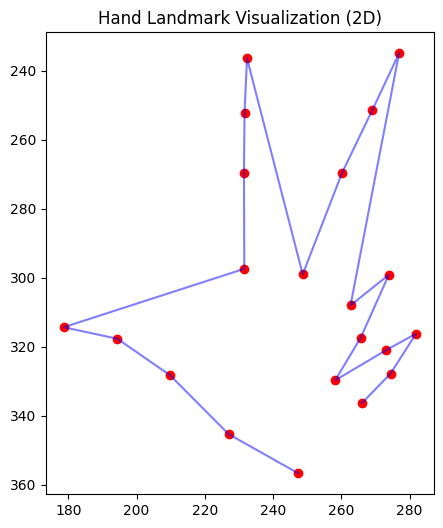

In [5]:
from mediapipe.python.solutions.hands import HAND_CONNECTIONS

row = df.iloc[22001]  # Change the index to visualize different samples

# Extract x, y, z coordinates
x = [row[f"x{i}"] for i in range(1, 22)]
y = [row[f"y{i}"] for i in range(1, 22)]
z = [row[f"z{i}"] for i in range(1, 22)]

plt.figure(figsize=(5, 6))
plt.scatter(x, y, color='red')  # Landmarks
plt.plot(x, y, color='blue', alpha=0.5)  # Connect points
plt.gca().invert_yaxis()  # Flip y-axis for correct visualization
plt.title("Hand Landmark Visualization (2D)")
plt.show()

# Hand Landmark Normalization

This cell performs normalization on the hand landmarks extracted from the HaGRID dataset using the following steps:

1. **Define a Function (`normalize_hand_landmarks`)**:
   - Translates all landmarks relative to the wrist (`x1`, `y1`), making it the new origin.
   - Computes a scaling factor based on the Euclidean distance between the wrist and the middle fingertip (`x9`, `y9`).
   - Normalizes all 21 landmark coordinates by subtracting the wrist position and dividing by the scaling factor to ensure scale invariance.

2. **Apply Normalization to the Dataset**:
   - The `normalize_hand_landmarks` function is applied to each row of the DataFrame (`df`), modifying the x and y coordinates of all landmarks.

3. **Save the Processed Data**:
   - The normalized dataset is saved as `normalized_hagrid.csv` for further analysis.

Finally, the script prints a confirmation message:

**"Hand landmark normalization completed!"**


In [6]:
import numpy as np

# Function to normalize hand landmarks while keeping labels unchanged
def normalize_hand_landmarks(row):
    # Step 1: Wrist coordinates (New Origin)
    x_wrist, y_wrist = row["x1"], row["y1"]
    
    # Step 2: Middle fingertip coordinates (Scaling reference)
    x_tip, y_tip = row["x9"], row["y9"]

    # Compute scaling factor (distance from wrist to middle fingertip)
    scale = np.sqrt((x_tip - x_wrist) ** 2 + (y_tip - y_wrist) ** 2)
    
    # Avoid division by zero
    if scale == 0:
        return row  # Return original if scaling factor is zero
    
    # Create a copy to prevent modifying original row
    normalized_row = row.copy()
    
    # Normalize all x, y coordinates (excluding labels)
    for i in range(1, 22):  # Loop through 21 landmarks
        normalized_row[f"x{i}"] = (row[f"x{i}"] - x_wrist) / scale
        normalized_row[f"y{i}"] = (row[f"y{i}"] - y_wrist) / scale
    
    return normalized_row

# Apply normalization to all rows
df.iloc[:, :-1] = df.iloc[:, :-1].apply(normalize_hand_landmarks, axis=1)

# Save the processed dataset
df.to_csv("normalized_hagrid.csv", index=False)

print("Hand landmark normalization completed!")

Hand landmark normalization completed!


In [7]:
df.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
count,25675.0,25675.0,2.567500e+04,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,...,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000
mean,0.0,0.0,1.272461e-07,0.012402,-0.121916,-0.009465,0.022132,-0.289314,-0.015946,0.026735,...,-0.024129,0.008219,-0.470805,-0.033751,0.007937,-0.465236,-0.032208,0.008449,-0.468324,-0.028828
std,0.0,0.0,2.737932e-07,0.190065,0.175589,0.010376,0.346998,0.327772,0.013973,0.428971,...,0.015658,0.531115,0.324472,0.020453,0.534885,0.366833,0.020877,0.550107,0.420201,0.021136
min,0.0,0.0,-2.029986e-06,-1.210274,-0.905379,-0.096630,-2.837942,-1.595619,-0.155846,-3.627787,...,-0.201897,-5.912827,-7.188946,-0.286821,-6.375586,-8.336673,-0.286470,-6.720245,-9.138822,-0.262047
25%,0.0,0.0,-5.243216e-08,-0.152485,-0.170788,-0.015199,-0.246438,-0.364969,-0.023020,-0.234032,...,-0.030728,-0.239350,-0.604519,-0.042726,-0.232753,-0.706922,-0.041957,-0.221396,-0.790508,-0.039220
50%,0.0,0.0,1.497277e-07,0.086253,-0.114165,-0.008737,0.088965,-0.289362,-0.014231,0.028370,...,-0.020969,-0.046453,-0.488998,-0.029942,-0.030561,-0.425053,-0.028510,-0.017268,-0.359459,-0.025269
75%,0.0,0.0,2.989988e-07,0.163811,-0.077198,-0.002783,0.274706,-0.229834,-0.007134,0.311099,...,-0.013661,0.239788,-0.384786,-0.019987,0.234098,-0.302049,-0.017971,0.224071,-0.239012,-0.014294
max,0.0,0.0,1.876254e-06,0.714318,1.846352,0.076365,1.363112,3.902050,0.094131,1.697781,...,0.031774,3.011945,1.156882,0.078105,3.512159,1.356580,0.104580,3.899551,1.604093,0.118668


# Encoding the Label Column

- The `label` column contains categorical values (gesture names) that need to be converted into numerical format for machine learning models.
- We use **LabelEncoder** from `sklearn.preprocessing` to transform the labels into numerical values.
- The `.fit_transform()` method assigns a unique integer to each label.
- Finally, `df['label'].unique()` displays the unique encoded values.


In [8]:
# Encode the label column
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

# Preparing Features and Target Variables

- `X`: Contains the input features by dropping the `label` column and all `z`-coordinate columns (from `z1` to `z21`).
  - The `z`-coordinates are removed because they represent depth, which may not be necessary for classification in a 2D space.
- `y`: Stores the target variable, which is the encoded gesture label.
- This step ensures that our model only trains on relevant hand landmark coordinates (x and y).


In [9]:
X = df.drop(['label'], axis=1)
y = df['label']

In [10]:
X.columns

Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4',
       'x5', 'y5', 'z5', 'x6', 'y6', 'z6', 'x7', 'y7', 'z7', 'x8', 'y8', 'z8',
       'x9', 'y9', 'z9', 'x10', 'y10', 'z10', 'x11', 'y11', 'z11', 'x12',
       'y12', 'z12', 'x13', 'y13', 'z13', 'x14', 'y14', 'z14', 'x15', 'y15',
       'z15', 'x16', 'y16', 'z16', 'x17', 'y17', 'z17', 'x18', 'y18', 'z18',
       'x19', 'y19', 'z19', 'x20', 'y20', 'z20', 'x21', 'y21', 'z21'],
      dtype='object')

In [11]:
y

0         0
1         0
2         0
3         0
4         0
         ..
25670    17
25671    17
25672    17
25673    17
25674    17
Name: label, Length: 25675, dtype: int32

# Splitting the Dataset into Training and Testing Sets

- We use `train_test_split` from `sklearn.model_selection` to divide the dataset into training and testing sets.
- `test_size = 0.20`: 20% of the data is reserved for testing, while 80% is used for training.
- `random_state = 42`: Ensures reproducibility of results.
- `shuffle = True`: Randomly shuffles the dataset before splitting.
- `stratify = y`: Ensures that the class distribution remains balanced between training and testing sets.


In [12]:
from sklearn.model_selection import train_test_split

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, random_state =42 \
                                                    , test_size = 0.20, shuffle = True, stratify = y)

# Training a Random Forest Classifier

- We use `RandomForestClassifier` from `sklearn.ensemble`, a robust ensemble learning method.
- `n_estimators = 50`: The model consists of 50 decision trees to improve accuracy and reduce overfitting.
- `random_state = 42`: Ensures reproducibility of results.
- `.fit(X_train_scaled, y_train)`: Trains the model using the standardized training data.
- `.predict(X_train_scaled)`: Predicts labels for the training set to evaluate how well the model has learned.
- `.predict(X_test_scaled)`: Predicts labels for the test set to assess generalization performance.


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators= 100, random_state = 42)
classifier.fit(X_train_scaled, y_train)

y_pred_train = classifier.predict(X_train_scaled)
y_pred_test = classifier.predict(X_test_scaled)

train Accuracy: 100.00%
Test Accuracy: 97.88%


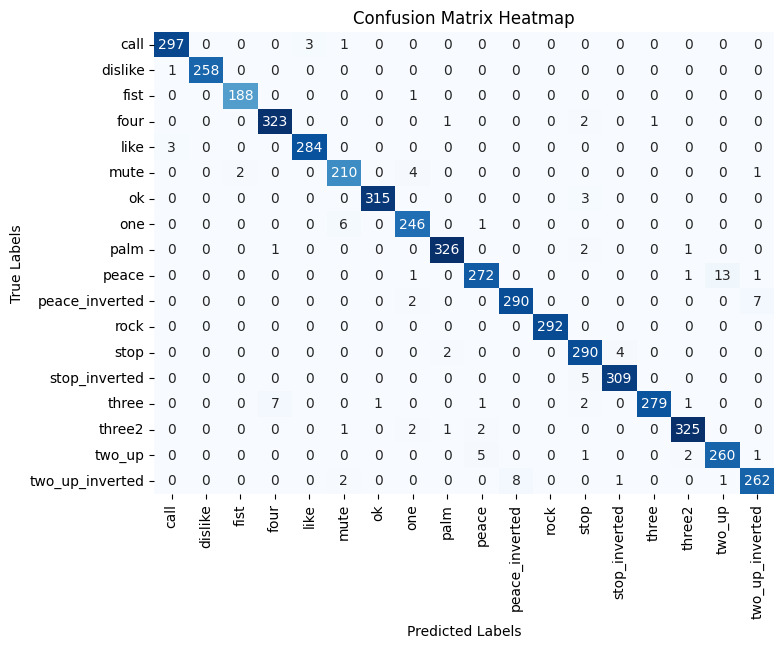

In [14]:
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'train Accuracy: {train_accuracy * 100:.2f}%')

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [15]:
print(label_encoder.classes_)

['call' 'dislike' 'fist' 'four' 'like' 'mute' 'ok' 'one' 'palm' 'peace'
 'peace_inverted' 'rock' 'stop' 'stop_inverted' 'three' 'three2' 'two_up'
 'two_up_inverted']


# Hyperparameter Tuning Using RandomizedSearchCV

Since the initial Random Forest model exhibited **underfitting**, we perform **hyperparameter tuning** to improve generalization.

## Steps:
- **Define a parameter grid (`param_dist`)**:
  - `n_estimators`: Number of trees in the forest (100, 120, 140).
  - `max_depth`: Maximum depth of each tree (None, 5, 10, 15).
  - `min_samples_split`: Minimum samples required to split a node (3 to 8).
  - `min_samples_leaf`: Minimum samples required at a leaf node (1, 2, 4).
  - `max_features`: Feature selection strategy (`'sqrt'`, `'log2'`) to reduce overfitting.

- **Use `RandomizedSearchCV`**:
  - `n_iter = 5`: Tests 5 different hyperparameter combinations.
  - `cv = 3`: Uses 3-fold cross-validation to evaluate each combination.
  - `n_jobs = -1`: Utilizes all available CPU cores for faster processing.
  - `random_state = 42`: Ensures reproducibility.

- **Train the optimized model**:
  - The best hyperparameters are extracted using `.best_params_`.
  - The best model (`best_rf`) is trained using these parameters.

- **Evaluate performance**:
  - Compute and print accuracy for both training and test sets.
  - This helps verify whether tuning has improved generalization.


In [16]:
# Because it's really overfitting we're going to try another set of H.P.
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 120 , 140],
    'max_depth' : [None, 5 ,10 ,15],
    'min_samples_split' : [3, 4, 5, 6, 7, 8],
    'min_samples_leaf' : [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# use regularization : 'max_features': ['sqrt', 'log2']

rf = RandomForestClassifier(random_state = 42)

random_search = RandomizedSearchCV(rf, param_distributions = param_dist,\
                                  n_iter = 5, cv=3, verbose = 2, n_jobs = -1 \
                                  , random_state = 42)
random_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", random_search.best_params_)

best_rf = random_search.best_estimator_

# Train Accuracy 
y_pred_train = best_rf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Optimized Train Accuracy: {train_accuracy * 100:.2f}%")

# Test accuracy
y_pred_test = best_rf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Optimized Test Accuracy: {test_accuracy * 100:.2f}%")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
Optimized Train Accuracy: 99.74%
Optimized Test Accuracy: 97.68%


# Training the Optimized Random Forest Model on Selected Features

- After hyperparameter tuning, we train the **best Random Forest model(`best_rf`)** using a refiend feature set
- **`X_train_selected`**  represents  a subset of the original features,possibly obtained through feature selection techinques.
- The model is trained  on this optimised dataset to further improve performance and reduce overfitting.

In [17]:
best_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=4, random_state=42)

# Evaluating the Optimized Random Forest Model

- **Predict on Training Data (`X_train_selected`)**:
  - Use the trained `best_rf` model to predict labels for the training set.
  - Compute **training accuracy** using `accuracy_score`.

- **Predict on Test Data (`X_test_selected`)**:
  - Evaluate the model's generalization by predicting labels for the test set.
  - Compute **test accuracy** using `accuracy_score`.

- **Print Accuracy Scores**:
  - Training accuracy helps assess how well the model fits the training data.
  - Test accuracy indicates how well the model generalizes to unseen data.


In [18]:
y_pred_train = best_rf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Optimized Train Accuracy: {train_accuracy * 100:.2f}%")

y_pred_test = best_rf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Optimized Test Accuracy: {test_accuracy * 100:.2f}%")

Optimized Train Accuracy: 99.74%
Optimized Test Accuracy: 97.68%


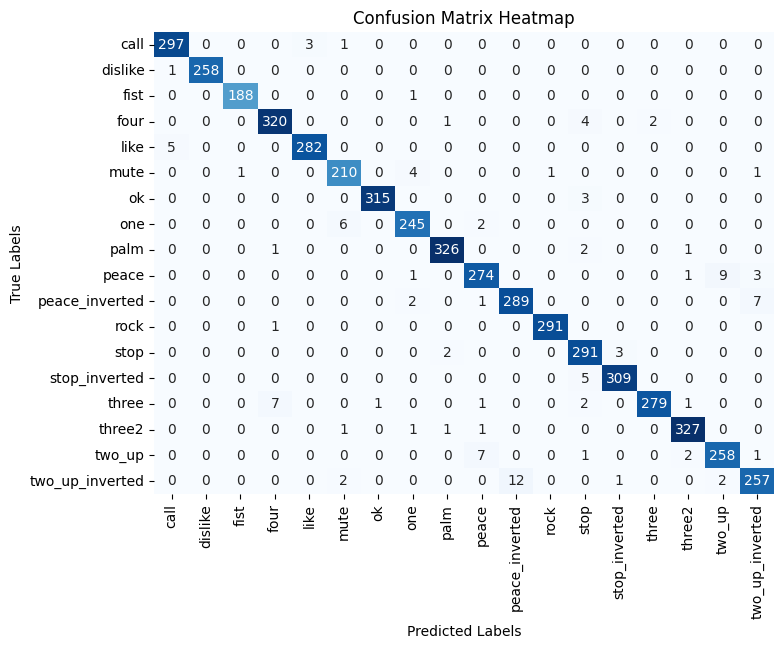

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Evaluating Model Performance Using Precision, Recall, and F1-Score

- **Precision** (`precision_score`): Measures how many of the predicted positive instances were actually correct.
- **Recall** (`recall_score`): Measures how many of the actual positive instances were correctly identified.
- **F1-Score** (`f1_score`): The harmonic mean of precision and recall, providing a balanced evaluation of model performance.

- We use `average='weighted'` to handle multi-class classification by computing a weighted mean of individual class scores.

- The results help assess the model’s ability to balance false positives and false negatives.


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.9769435139142941
Recall: 0.97682570593963
F1-Score: 0.9768351374232958


In [21]:
from sklearn.metrics import classification_report

print("Train Metrics:")
print(classification_report(y_train, y_pred_train))

print("Test Metrics:")
print(classification_report(y_test, y_pred_test))

Train Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1205
           1       1.00      1.00      1.00      1036
           2       1.00      1.00      1.00       756
           3       0.99      1.00      1.00      1307
           4       1.00      1.00      1.00      1149
           5       0.99      0.99      0.99       870
           6       1.00      1.00      1.00      1274
           7       0.99      0.99      0.99      1010
           8       1.00      1.00      1.00      1319
           9       1.00      0.99      1.00      1153
          10       1.00      1.00      1.00      1198
          11       1.00      1.00      1.00      1166
          12       1.00      1.00      1.00      1186
          13       1.00      1.00      1.00      1253
          14       1.00      0.99      0.99      1165
          15       1.00      1.00      1.00      1322
          16       1.00      1.00      1.00      1074
          17

# xgboost model

In [22]:
#import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(

    objective = "multi:softmax",
    num_class = len(label_encoder.classes_),
    eval_metric = 'mlogloss',
    random_state = 42
    
)

xgb_classifier.fit(X_train_scaled, y_train)

y_pred_train = xgb_classifier.predict(X_train_scaled)
y_pred_test = xgb_classifier.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)


print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy: 98.48%


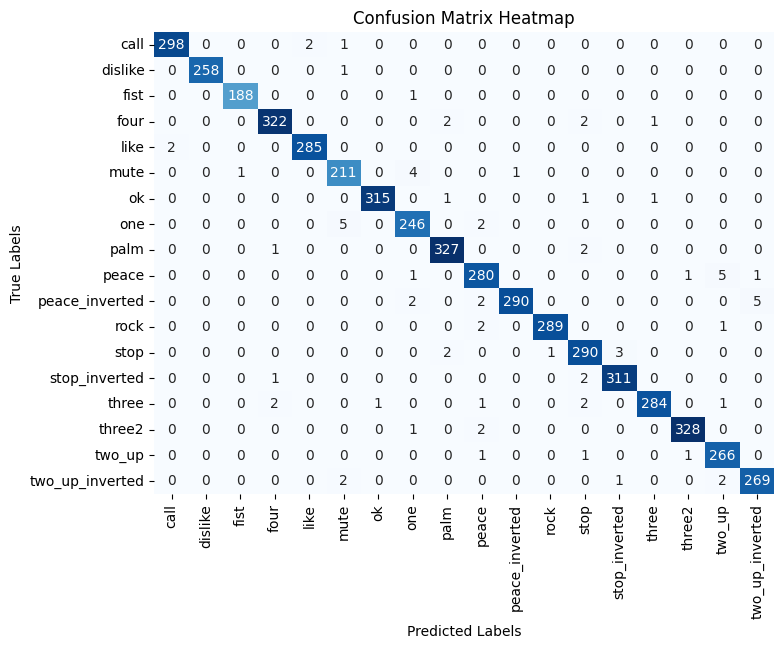

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [24]:
from sklearn.metrics import classification_report

print("Train Metrics:")
print(classification_report(y_train, y_pred_train))

print("Test Metrics:")
print(classification_report(y_test, y_pred_test))

Train Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1205
           1       1.00      1.00      1.00      1036
           2       1.00      1.00      1.00       756
           3       1.00      1.00      1.00      1307
           4       1.00      1.00      1.00      1149
           5       1.00      1.00      1.00       870
           6       1.00      1.00      1.00      1274
           7       1.00      1.00      1.00      1010
           8       1.00      1.00      1.00      1319
           9       1.00      1.00      1.00      1153
          10       1.00      1.00      1.00      1198
          11       1.00      1.00      1.00      1166
          12       1.00      1.00      1.00      1186
          13       1.00      1.00      1.00      1253
          14       1.00      1.00      1.00      1165
          15       1.00      1.00      1.00      1322
          16       1.00      1.00      1.00      1074
          17

# XGBoost Model Saving

After training the XGBoost model, we achieved **outstanding accuracy**:

- **Train Accuracy**: 100.00% ✅
- **Test Accuracy**: 98.48% ✅

These results indicate that the model has learned the training data perfectly while maintaining excellent generalization to unseen test data.

To preserve the model for future use, we save both:

1. **The trained XGBoost model** (`xgboost_model.pkl`)
2. **The LabelEncoder** (`label_encoder.pkl`)

This ensures that we can later reload the model and correctly map predicted labels back to their original categories.

## Next Steps:
- Deploy the model for real-world classification tasks.
- Evaluate further to ensure robustness on additional test data.

 *Model and LabelEncoder saved successfully!*


In [25]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb_classifier, "xgboost_model.pkl")

# Save the LabelEncoder
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model and LabelEncoder saved successfully!")

Model and LabelEncoder saved successfully!


# SVM

## Training and Evaluating an SVM Model

To further explore classification performance, we implement a **Support Vector Machine (SVM)** model with an **RBF (Radial Basis Function) kernel**.

## Steps:

1. **Define the SVM Model** (`SVC`):
    - `kernel='rbf'`: Uses a **Radial Basis Function (RBF)** kernel to capture complex relationships.
    - `C=1.0`: Regularization parameter to control margin width.
    - `gamma='scale'`: Automatically sets the kernel coefficient.
    - `random_state=42`: Ensures reproducibility.

2. **Train the Model**:
    - Fit `svm_classifier` on the scaled training data.

3. **Make Predictions**:
    - Predict labels for both training (`X_train_scaled`) and test (`X_test_scaled`) datasets.

4. **Evaluate Model Performance**:
    - Compute **training accuracy** and **test accuracy** using `accuracy_score`.
    - Compare results to identify signs of overfitting or underfitting.


In [26]:
# Define SVM model
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', C=1.0,
                     gamma='scale', random_state=42)

# Train Model
svm_classifier.fit(X_train_scaled, y_train)

# Predict on Train & Test Set
y_pred_train = svm_classifier.predict(X_train_scaled)
y_pred_test = svm_classifier.predict(X_test_scaled)

# Evaluate Performance
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 95.95%
Test Accuracy: 96.11%


# Hyperparameter Tuning for SVM

To improve the **SVM classifier's** performance, we perform **hyperparameter tuning** using `RandomizedSearchCV`.

## Steps:

1. **Define the Hyperparameter Grid** (`param_dist`):
    - `C`: Regularization parameter (0.1, 1, 10, 100).
    - `gamma`: Controls the influence of each training sample (`'scale'`, `'auto'`, 0.01, 0.1, 1).
    - `kernel`: Tests different kernel functions (`'rbf'`, `'linear'`, `'poly'`, `'sigmoid'`).

2. **Apply** `RandomizedSearchCV`:
    - `n_iter=20`: Tests 20 random hyperparameter combinations.
    - `cv=3`: Uses **3-fold cross-validation**.
    - `n_jobs=-1`: Utilizes all CPU cores for faster computation.
    - `random_state=42`: Ensures reproducibility.

3. **Train the Best Model** (`best_svm`):
    - The best hyperparameters are extracted using `.best_params_`.
    - The optimized model (`best_svm`) is trained using the best settings.

4. **Evaluate Performance**:
    - Compute **training** and **test accuracy** using `accuracy_score`.
    - Helps determine whether SVM outperforms other models (Random Forest, XGBoost).


In [27]:
param_dist = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Try different kernels
}

random_search = RandomizedSearchCV(
    svm_classifier, param_distributions=param_dist,
    n_iter=20, cv=3, verbose=2, n_jobs=-1, random_state=42
)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_svm = random_search.best_estimator_

# Predict with Best Model
y_pred_train = best_svm.predict(X_train_scaled)
y_pred_test = best_svm.predict(X_test_scaled)

# Evaluate Again
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Optimized Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Optimized Test Accuracy: {test_accuracy * 100:.2f}%")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'kernel': 'poly', 'gamma': 1, 'C': 0.1}
Optimized Train Accuracy: 99.40%
Optimized Test Accuracy: 98.79%


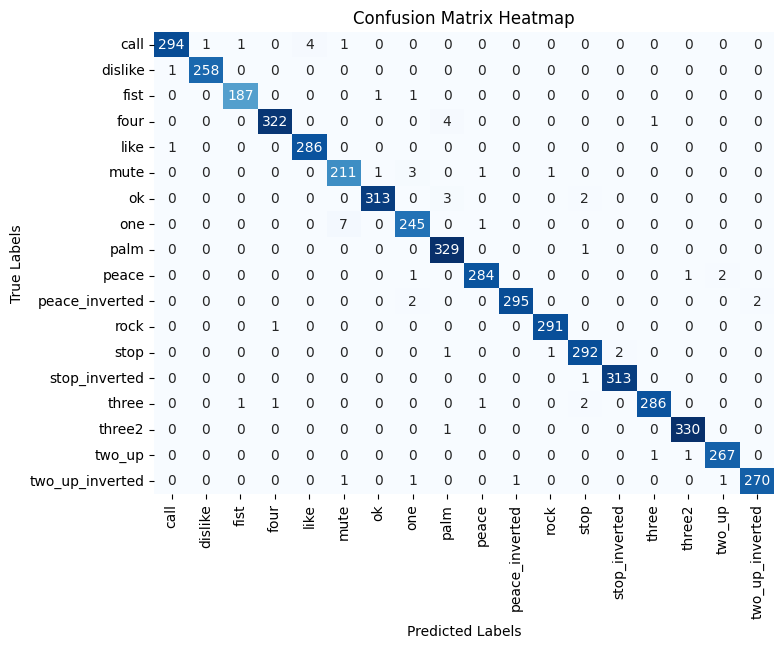

In [28]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'g', cmap ='Blues', cbar = False,
           xticklabels = class_names, yticklabels = class_names)


plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [29]:
from sklearn.metrics import classification_report

print("Train Metrics:")
print(classification_report(y_train, y_pred_train))

print("Test Metrics:")
print(classification_report(y_test, y_pred_test))

Train Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1205
           1       1.00      1.00      1.00      1036
           2       1.00      1.00      1.00       756
           3       0.98      1.00      0.99      1307
           4       1.00      1.00      1.00      1149
           5       0.98      0.99      0.98       870
           6       1.00      1.00      1.00      1274
           7       0.99      0.98      0.98      1010
           8       1.00      0.99      0.99      1319
           9       0.99      0.99      0.99      1153
          10       1.00      0.99      1.00      1198
          11       1.00      1.00      1.00      1166
          12       0.98      0.99      0.99      1186
          13       0.99      0.99      0.99      1253
          14       1.00      0.98      0.99      1165
          15       1.00      1.00      1.00      1322
          16       0.99      1.00      0.99      1074
          17

# SVM Model Saving

After training the XGBoost model, we achieved **outstanding accuracy**:

- **Train Accuracy**: 99.40% ✅
- **Test Accuracy**: 98.79% ✅

These results indicate that the model has learned the training data perfectly while maintaining excellent generalization to unseen test data.

To preserve the model for future use, we save both:

1. **The trained SVM model** (`svm_model.pkl`)
2. **The LabelEncoder** (`label_encoder.pkl`)

This ensures that we can later reload the model and correctly map predicted labels back to their original categories.

## Next Steps:

- Deploy the model for real-world classification tasks.
- Evaluate further to ensure robustness on additional test data.

> 🚀 *Model and LabelEncoder saved successfully!*


In [30]:
import joblib

# Save the trained svm model
joblib.dump(svm_classifier, "svm_model.pkl")

# Save the LabelEncoder
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model and LabelEncoder saved successfully!")

Model and LabelEncoder saved successfully!


# Real-Time Hand Gesture Classification using MediaPipe and XGBoost

This script captures live video from a webcam, detects hand landmarks using MediaPipe, and classifies hand gestures using a trained XGBoost model. The predicted gestures are displayed on the video feed, and the processed video is saved for later analysis.

## Features:

- **Hand Landmark Detection**: Uses MediaPipe Hands to extract 3D landmarks of detected hands.
- **Normalization**: The landmarks are normalized relative to the wrist and index fingertip for robustness.
- **Gesture Classification**: A pre-trained XGBoost model predicts the gesture based on the normalized landmarks.
- **Smoothing**: A sliding window of predictions (mode of the last 10 frames) ensures stable classification.
- **Video Recording**: Saves the processed video with detected gestures.
- **Live Display**: Shows the real-time video feed with overlaid gesture predictions.

## How It Works:

1. Captures a video frame and processes it with MediaPipe.
2. Extracts and normalizes hand landmarks.
3. Uses XGBoost to classify the gesture based on the processed features.
4. Displays the predicted gesture on the screen.
5. Writes the processed frames to an output video file.
6. Stops when the 'q' key is pressed.

## Requirements:

- OpenCV (`cv2`)
- Mediapipe(`mediapipe`)
- Numpy(`numpy`)
- XGBoost(`joblib` for loading the model)
- Python 3.x

# To Save The Record

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
from collections import Counter  # To compute mode

# Load trained XGBoost model and LabelEncoder
xgb = joblib.load("xgboost_model.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# Initialize MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Open webcam
cap = cv2.VideoCapture(0)

# Get video width, height, and frames per second (fps)
frame_width = int(cap.get(3))  # Width
frame_height = int(cap.get(4))  # Height
fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30  # Use 30 FPS if undefined

# Define video writer (to save the stream)
output_filename = "gesture_tracking.avi"  # Change to "gesture_tracking.mp4" if using mp4
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec (use 'mp4v' for MP4)
out = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))

# Prediction history for smoothing
WINDOW_SIZE = 10  # Number of frames to consider for mode
prediction_history = []  # Stores last `WINDOW_SIZE` predictions

# Function to normalize landmarks (including z-coordinate)
def normalize_landmarks(landmarks):
    x_wrist, y_wrist, z_wrist = landmarks[0]
    x_tip, y_tip, z_tip = landmarks[8]

    scale = np.sqrt((x_tip - x_wrist) ** 2 + (y_tip - y_wrist) ** 2)
    if scale == 0:
        return None

    normalized = [((x - x_wrist) / scale, (y - y_wrist) / scale, (z - z_wrist) / scale) for x, y, z in landmarks]
    return np.array(normalized).flatten()

# Function to compute mode of predictions
def get_stable_prediction(history):
    if len(history) == 0:
        return None
    most_common = Counter(history).most_common(1)
    return most_common[0][0]

# Run MediaPipe Hand Tracking
with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert image from BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = hands.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Default message
        label_text = "No Hand Detected"

        # If a hand is detected
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
                normalized_landmarks = normalize_landmarks(landmarks)
                
                if normalized_landmarks is not None:
                    input_data = normalized_landmarks.reshape(1, -1)
                    prediction = xgb.predict(input_data)
                    predicted_label = label_encoder.inverse_transform(prediction)[0]

                    prediction_history.append(predicted_label)
                    if len(prediction_history) > WINDOW_SIZE:
                        prediction_history.pop(0)

                    stable_prediction = get_stable_prediction(prediction_history)
                    label_text = f"Gesture: {stable_prediction}"

                # Draw hand landmarks
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Add text with black background for visibility
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2
        text_color = (0, 255, 0)  # Green
        bg_color = (0, 0, 0)  # Black
        text_size = cv2.getTextSize(label_text, font, font_scale, font_thickness)[0]

        x, y, w, h = 10, 10, text_size[0] + 20, text_size[1] + 20
        cv2.rectangle(image, (x, y), (x + w, y + h), bg_color, -1)  # Black background
        cv2.putText(image, label_text, (x + 10, y + h - 10), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

        # Write the frame to the video file
        out.write(image)

        # Show the video feed
        cv2.imshow('Hand Tracking', image)

        # Exit on 'q' key press
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
out.release()  # Save the video file
cv2.destroyAllWindows()

## *toshit* 
- kanha 
- `kanha`